# APA API Demonstration Notebook

This notebook demonstrates all stages of the APA (Advanced Pavement Analytics) API.

## Overview

The APA API provides a modular, plug-and-play architecture for:
- Data import from various sources
- Data processing (ROI, road extraction, PCI segmentation)
- Model training and prediction
- Pipeline orchestration

All modules automatically handle input/output parsing, validation, and error handling.


## Setup and Imports


In [1]:
import sys
import os
from pathlib import Path

# Add src to path so apa package can be imported
# This matches the pattern used in other examples like common_api_usage.py
project_root = Path().absolute().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Any

# APA imports - use apa. prefix as expected by the package structure
from apa.common import (
    DataContainer,
    ProcessingResult,
    ModelResult,
    PipelineResult,
    BaseModule,
    BaseDataProcessor,
    BaseModel,
    BasePipeline,
)

from apa.modules import (
    HyperspectralDataImporter,
    GroundTruthDataImporter,
    RoadDataImporter,
    ROIProcessor,
    RoadExtractor,
    PCISegmenter,
    DataPreprocessor,
    UNetModel,
    CNNModel,
    ModelManager,
    APAPipeline,
    ModularPipeline,
)

from apa.utils import (
    IOUtils,
    VisualizationUtils,
    MetricsCalculator,
)

from apa.config import ConfigManager

print("✓ All imports successful!")


✓ All imports successful!


## Configuration Loading

Load configuration from YAML file. The config contains all parameters needed for data import, processing, and model training.

**ConfigManager** is defined in `src/apa/config/manager.py` and provides:
- `load_config(config_path)`: Load and parse YAML configuration files
- `validate_config(config)`: Validate configuration against schema
- `create_config_from_template()`: Create configs from templates
- `merge_with_defaults()`: Merge user config with defaults


In [2]:
# Load configuration from YAML file
config_manager = ConfigManager()

# Load the config file - adjust path as needed
config_path = project_root / "configs" / "apa_config_detroit_Aribus_2025.yaml"
config_data = config_manager.load_config(str(config_path))

# Extract the config dictionary (ConfigManager returns {'config': {...}, 'path': '...'})
config = config_data['config']

print(f"✓ Configuration loaded from: {config_data['path']}")
print(f"  Data source: {config['data'].get('enum_data_source', 'N/A')}")
print(f"  Input path: {config['data'].get('input_path', 'N/A')}")
print(f"  Zone: {config['data'].get('zone', 'N/A')}")
print(f"  Big TIFF: {config['data'].get('big_tiff', 'N/A')}")


✓ Configuration loaded from: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/configs/apa_config_detroit_Aribus_2025.yaml
  Data source: 2
  Input path: data/detroit_2025/Multispectral
  Zone: Detroit
  Big TIFF: False


## Stage 1: Data Import

The APA API supports importing data from multiple sources:
- Hyperspectral satellite imagery (VENUS, Airbus)
- Ground truth PCI data
- Road network data (OpenStreetMap, GeoJSON)


### 1.1 Hyperspectral Data Import


In [3]:
# Create hyperspectral data importer using loaded config
# The config is already in nested format (config['data']), which the importer supports
hyperspectral_config = config['data']  # Use the data section from loaded config

importer = HyperspectralDataImporter(hyperspectral_config)
print(f"Created importer: {importer.name}")
print(f"Required config keys: {importer.required_config_keys}")
print(f"Dataset: {hyperspectral_config.get('enum_data_source', 'N/A')}")
print(f"Input path: {hyperspectral_config.get('input_path', 'N/A')}")
print(f"Filename NED: {hyperspectral_config.get('filename_NED', 'N/A')}")


Created importer: hyperspectral_importer
Required config keys: ['input_path']
Dataset: 2
Input path: data/detroit_2025/Multispectral
Filename NED: IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_1_NED_R1C1.TIF


In [4]:
# Load hyperspectral data
# Note: This will use dummy data if actual files aren't found
import os

print("Debugging file path resolution...")
print(f"  Current working directory: {os.getcwd()}")
print(f"  Config input_path: {hyperspectral_config.get('input_path', 'N/A')}")
print(f"  Config filename_NED: {hyperspectral_config.get('filename_NED', 'N/A')}")

# Check if file exists in various locations
input_path = hyperspectral_config.get('input_path', '')
filename = hyperspectral_config.get('filename_NED', '')
if input_path and filename:
    test_paths = [
        os.path.join(os.getcwd(), input_path, filename),
        os.path.join(input_path, filename),
        os.path.join(project_root, input_path, filename),
        os.path.abspath(os.path.join(input_path, filename)),
    ]
    print("\n  Checking file existence:")
    for test_path in test_paths:
        exists = "✓ EXISTS" if os.path.exists(test_path) else "✗ NOT FOUND"
        print(f"    {exists}: {test_path}")

print("\nAttempting to load data...")
try:
    hyperspectral_data = importer.load_data()
    print(f"\n✓ Data loaded successfully!")
    print(f"  Data type: {hyperspectral_data.data_type}")
    
    # Data is now a dictionary with 'image', 'lon_mat', 'lat_mat'
    if isinstance(hyperspectral_data.data, dict):
        image = hyperspectral_data.data['image']
        lon_mat = hyperspectral_data.data['lon_mat']
        lat_mat = hyperspectral_data.data['lat_mat']
        print(f"  Image shape: {image.shape}")
        print(f"  Image dtype: {image.dtype}")
        print(f"  Image value range: [{np.min(image):.2f}, {np.max(image):.2f}]")
        print(f"  Lon mat shape: {lon_mat.shape}")
        print(f"  Lon range: [{np.min(lon_mat):.6f}, {np.max(lon_mat):.6f}]")
        print(f"  Lat mat shape: {lat_mat.shape}")
        print(f"  Lat range: [{np.min(lat_mat):.6f}, {np.max(lat_mat):.6f}]")
        print(f"  Container shape (from image): {hyperspectral_data.shape}")
        print(f"  ROIs: {hyperspectral_data.metadata.get('rois', 'N/A')}")
    elif isinstance(hyperspectral_data.data, np.ndarray):
        # Legacy format: data is directly a numpy array
        print(f"  Shape: {hyperspectral_data.shape}")
        print(f"  Data shape: {hyperspectral_data.data.shape}")
    else:
        print(f"  Data type: {type(hyperspectral_data.data)}")
        print(f"  Shape: {hyperspectral_data.shape}")
    
    print(f"\n  Metadata keys: {list(hyperspectral_data.metadata.keys())}")


except Exception as e:
    print(f"\n⚠ Error loading data: {str(e)}")
    print("\nFull error traceback:")
    import traceback
    traceback.print_exc()
    print("\n" + "="*60)
    print("Creating dummy data for demonstration...")
    print("="*60)
    # Create dummy data for demonstration
    dummy_image = np.random.rand(200, 200, 1).astype(np.float32)  # Panchromatic = 1 band
    dummy_lon = np.random.rand(200, 200).astype(np.float32) * 0.1 - 83.0
    dummy_lat = np.random.rand(200, 200).astype(np.float32) * 0.1 + 42.3
    hyperspectral_data = DataContainer(
        data={
            'image': dummy_image,
            'lon_mat': dummy_lon,
            'lat_mat': dummy_lat
        },
        metadata={
            'source': 'demo',
            'dataset': 'airbus_Pan_Detroit',
            'rois': [[42.3, 42.4, -83.0, -82.9]]
        },
        data_type='hyperspectral'
    )
    print(f"  ✓ Created dummy data with image shape: {dummy_image.shape}")
    print(f"\n  To fix the file path issue:")
    print(f"    1. Check that the file exists at one of the paths shown above")
    print(f"    2. Update the 'input_path' in the config if needed")
    print(f"    3. Or provide an absolute path to the file")


Debugging file path resolution...
  Current working directory: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/examples
  Config input_path: data/detroit_2025/Multispectral
  Config filename_NED: IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_1_NED_R1C1.TIF

  Checking file existence:
    ✗ NOT FOUND: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/examples/data/detroit_2025/Multispectral/IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_1_NED_R1C1.TIF
    ✗ NOT FOUND: data/detroit_2025/Multispectral/IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_1_NED_R1C1.TIF
    ✓ EXISTS: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/detroit_2025/Multispectral/IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_1_NED_R1C1.TIF
    ✗ NOT FOUND: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/examples/data/detroit_2025/Multispectral/IMG_PNEO4_STD_202301091639366_MS-FS_ORT_PWOI_000371696_1_1_F_

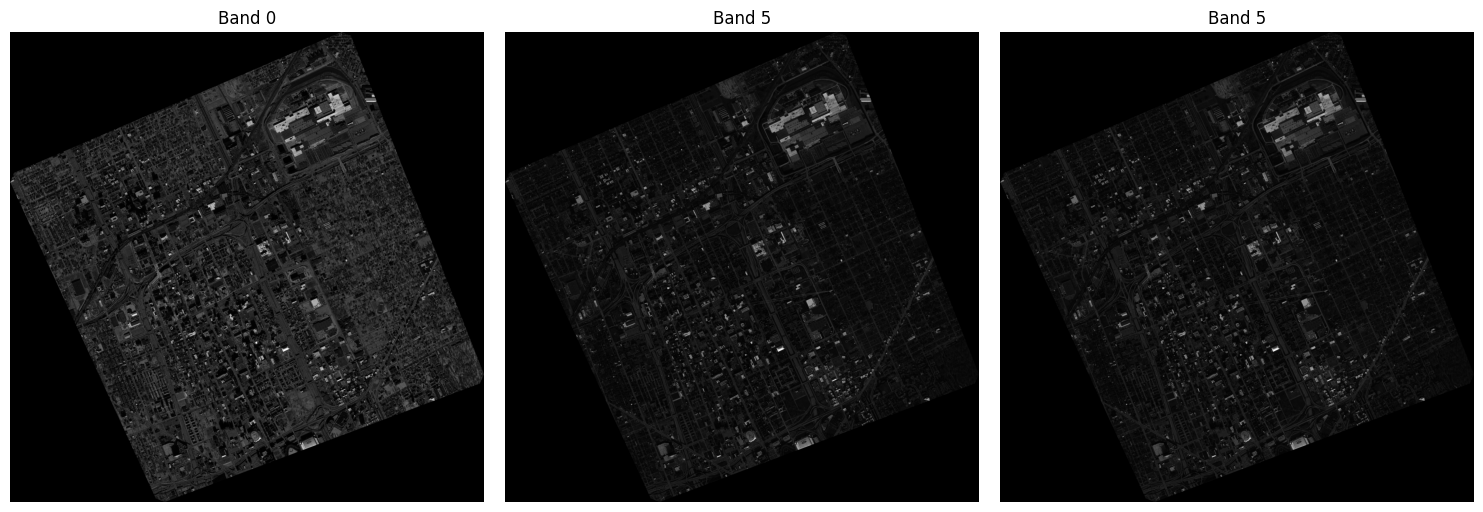

In [5]:
# Visualize hyperspectral data (first 3 bands as RGB)
# Handle both dictionary and array formats
if isinstance(hyperspectral_data.data, dict):
    image = hyperspectral_data.data['image']
    if len(image.shape) == 3:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Show first 3 bands
        for i, band_idx in enumerate([0, 5, min(11, image.shape[2]-1)]):
            if band_idx < image.shape[2]:
                axes[i].imshow(image[:, :, band_idx], cmap='gray')
                axes[i].set_title(f'Band {band_idx}')
                axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Data visualization skipped (image shape: {image.shape})")
elif isinstance(hyperspectral_data.data, np.ndarray) and len(hyperspectral_data.data.shape) == 3:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Show first 3 bands
    for i, band_idx in enumerate([0, 5, 11]):
        if band_idx < hyperspectral_data.data.shape[2]:
            axes[i].imshow(hyperspectral_data.data[:, :, band_idx], cmap='gray')
            axes[i].set_title(f'Band {band_idx}')
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Data visualization skipped (not a 3D array or dict)")


### 1.2 Ground Truth PCI Data Import


In [6]:
# Create ground truth importer using loaded config
# The config provides both label_file (CSV) and PCI_path (H5) options
# We'll use label_file for CSV format, or PCI_path for H5 format

# Check which file exists or prefer CSV (label_file) if available
if 'label_file' in config['data'] and config['data']['label_file']:
    # Use CSV file from config
    label_file_path = config['data']['label_file']
    # Remove leading slash if present (config has "/Detroit/...")
    if label_file_path.startswith('/'):
        label_file_path = label_file_path[1:]
    
    # Construct full path relative to project root
    # Config has "/Detroit/Pavement_Condition.csv", actual file is at "data/Detroit/Pavement_Condition.csv"
    # Build path: project_root / "data" / label_file_path
    label_file_full_path = project_root / "data" / label_file_path
    
    # Convert to string for the importer
    label_file_str = str(label_file_full_path)
    
    ground_truth_config = {
        'input_path': label_file_str,
        'file_format': 'auto',  # Auto-detect from extension (.csv)
        'isLatLon': True,  # Assuming CSV has lat/lon coordinates
    }
    print(f"Using label_file from config: {label_file_path}")
    print(f"  Full path: {label_file_str}")
elif 'PCI_path' in config['data'] and config['data']['PCI_path']:
    # Fallback to H5 file if CSV not available
    pci_path = config['data']['PCI_path']
    # Construct full path if relative
    if not os.path.isabs(pci_path):
        pci_path_full = project_root / pci_path
        pci_path = str(pci_path_full)
    
    ground_truth_config = {
        'input_path': pci_path,
        'file_format': 'h5',
    }
    print(f"Using PCI_path from config: {pci_path}")
else:
    # Fallback if neither is in config
    fallback_path = project_root / "data" / "Detroit" / "PCI_labels.h5"
    ground_truth_config = {
        'input_path': str(fallback_path),
        'file_format': 'h5',
    }
    print(f"⚠ No PCI file path found in config, using default: {fallback_path}")

gt_importer = GroundTruthDataImporter(ground_truth_config)
print(f"Created importer: {gt_importer.name}")
print(f"  Input path: {ground_truth_config['input_path']}")
print(f"  File format: {ground_truth_config.get('file_format', 'auto')}")
if 'isLatLon' in ground_truth_config:
    print(f"  isLatLon: {ground_truth_config['isLatLon']}")


Using label_file from config: Detroit/Pavement_Condition.csv
  Full path: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/Detroit/Pavement_Condition.csv
Created importer: ground_truth_importer
  Input path: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/Detroit/Pavement_Condition.csv
  File format: auto
  isLatLon: True


In [7]:
# Load ground truth PCI data
# Note: The importer now returns data as a dictionary with 'pci', 'lon', 'lat', 'seg_id' keys
try:
    print("Attempting to load ground truth data...")
    print(f"  Config input_path: {ground_truth_config['input_path']}")
    
    ground_truth_data = gt_importer.load_data()
    print(f"\n✓ Ground truth data loaded successfully!")
    print(f"  Data type: {ground_truth_data.data_type}")
    
    # Data is now a dictionary with 'pci', 'lon', 'lat', 'seg_id'
    if isinstance(ground_truth_data.data, dict):
        pci = ground_truth_data.data['pci']
        lon = ground_truth_data.data['lon']
        lat = ground_truth_data.data['lat']
        seg_id = ground_truth_data.data.get('seg_id')
        
        print(f"  PCI values shape: {pci.shape}")
        print(f"  PCI value range: [{np.min(pci):.1f}, {np.max(pci):.1f}]")
        print(f"  Number of points: {len(pci)}")
        print(f"  Lon range: [{np.min(lon):.6f}, {np.max(lon):.6f}]")
        print(f"  Lat range: [{np.min(lat):.6f}, {np.max(lat):.6f}]")
        if seg_id is not None:
            print(f"  Segment IDs: {len(seg_id)} segments")
        else:
            print(f"  Segment IDs: Not available")
        print(f"  Container shape (from PCI): {ground_truth_data.shape}")
    elif isinstance(ground_truth_data.data, np.ndarray):
        # Legacy format: data is directly a numpy array
        print(f"  Shape: {ground_truth_data.shape}")
        print(f"  Data shape: {ground_truth_data.data.shape}")
    else:
        print(f"  Data type: {type(ground_truth_data.data)}")
        print(f"  Shape: {ground_truth_data.shape}")
    
    print(f"\n  Metadata keys: {list(ground_truth_data.metadata.keys())}")
except Exception as e:
    print(f"\n⚠ Error loading ground truth data: {str(e)}")
    print("\nFull error traceback:")
    import traceback
    traceback.print_exc()
    print("\n" + "="*60)
    print("Creating dummy data for demonstration...")
    print("="*60)
    # Create dummy PCI data for demonstration (dictionary format)
    num_points = 1000
    dummy_pci = np.random.randint(0, 5, size=num_points, dtype=np.uint8)
    dummy_lon = np.random.rand(num_points) * 0.1 - 83.0
    dummy_lat = np.random.rand(num_points) * 0.1 + 42.3
    
    ground_truth_data = DataContainer(
        data={
            'pci': dummy_pci,
            'lon': dummy_lon,
            'lat': dummy_lat,
            'seg_id': None
        },
        metadata={
            'source': 'demo',
            'file_format': 'dummy'
        },
        data_type='ground_truth_pci'
    )
    print(f"  ✓ Created dummy PCI data with {num_points} points")
    print(f"  Note: This is dummy data. To load real data, ensure:")
    print(f"    1. The file path exists: {ground_truth_config['input_path']}")
    print(f"    2. Required modules are installed (pandas for CSV/Excel)")
    print(f"    3. The file format is supported (CSV, Excel, or HDF5)")


Attempting to load ground truth data...
  Config input_path: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/Detroit/Pavement_Condition.csv

✓ Ground truth data loaded successfully!
  Data type: ground_truth_pci
  PCI values shape: (227229,)
  PCI value range: [1.0, 3.0]
  Number of points: 227229
  Lon range: [-84.149255, -82.423428]
  Lat range: [41.724177, 43.162884]
  Segment IDs: 227229 segments
  Container shape (from PCI): None

  Metadata keys: ['input_path', 'file_format', 'data_type', 'isLatLon']


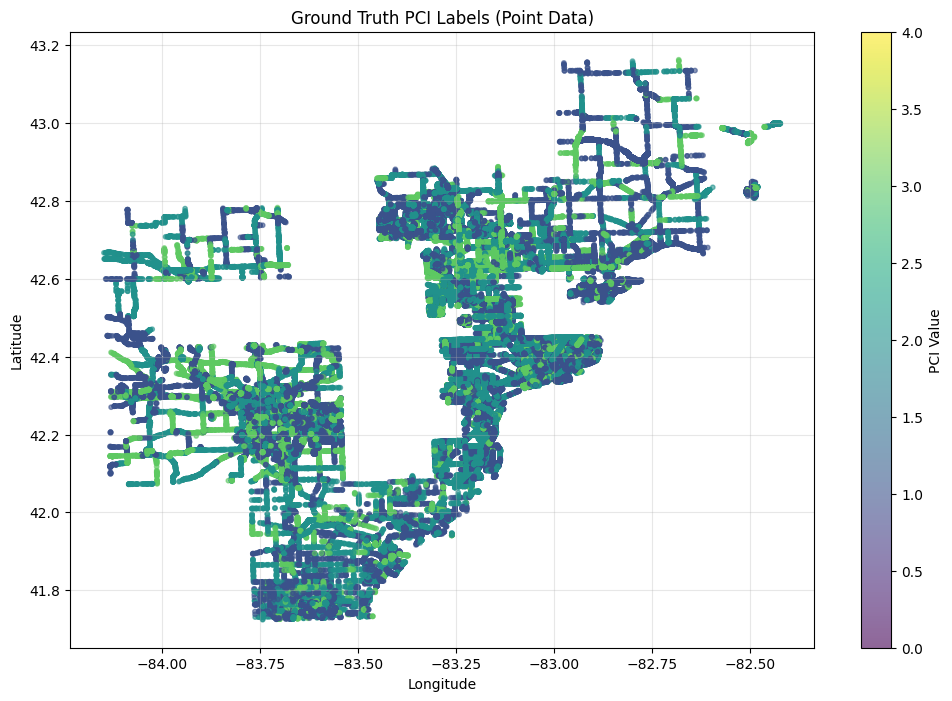

PCI value distribution:
  PCI 1: 95721 points (42.1%)
  PCI 2: 82112 points (36.1%)
  PCI 3: 49396 points (21.7%)


In [8]:
# Visualize ground truth PCI labels
# Handle both dictionary format (new) and array format (legacy)
if isinstance(ground_truth_data.data, dict):
    # New format: dictionary with 'pci', 'lon', 'lat', 'seg_id'
    pci = ground_truth_data.data['pci']
    lon = ground_truth_data.data['lon']
    lat = ground_truth_data.data['lat']
    
    # Create scatter plot of PCI points
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(lon, lat, c=pci, cmap='viridis', vmin=0, vmax=4, s=10, alpha=0.6)
    plt.colorbar(scatter, label='PCI Value')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Ground Truth PCI Labels (Point Data)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Show distribution
    unique, counts = np.unique(pci, return_counts=True)
    print(f"PCI value distribution:")
    for val, count in zip(unique, counts):
        print(f"  PCI {val}: {count} points ({100*count/len(pci):.1f}%)")
elif isinstance(ground_truth_data.data, np.ndarray):
    # Legacy format: 2D array (image-like)
    plt.figure(figsize=(10, 8))
    plt.imshow(ground_truth_data.data, cmap='viridis', vmin=0, vmax=4)
    plt.colorbar(label='PCI Value')
    plt.title('Ground Truth PCI Labels')
    plt.axis('off')
    plt.show()
    
    # Show distribution
    unique, counts = np.unique(ground_truth_data.data, return_counts=True)
    print(f"PCI value distribution:")
    for val, count in zip(unique, counts):
        print(f"  PCI {val}: {count} pixels ({100*count/ground_truth_data.data.size:.1f}%)")
else:
    print(f"Visualization skipped: Unsupported data format ({type(ground_truth_data.data)})")


### 1.3 Road Network Data Import


In [9]:
# Create road data importer using loaded config
# The new RoadDataImporter loads road masks from NPZ files or creates them from OpenStreetMap
# It requires the full config with 'data' and 'preprocessing' sections, and hyperspectral_data

# RoadDataImporter will use:
# - config['data']['enum_data_source'] to add suffix to NPZ filename
# - config['preprocessing']['georeferencing']['osx_map_mask_path'] for NPZ file path
# - hyperspectral_data (with lon_mat, lat_mat, rois) to create/load the mask

road_importer = RoadDataImporter(config)  # Pass full config
print(f"Created importer: {road_importer.name}")
print(f"  Config enum_data_source: {config['data'].get('enum_data_source', 'N/A')}")
if 'preprocessing' in config and 'georeferencing' in config['preprocessing']:
    osx_path = config['preprocessing']['georeferencing'].get('osx_map_mask_path', 'N/A')
    print(f"  OSX map mask path: {osx_path}")
else:
    print(f"  OSX map mask path: Using default")


Created importer: road_importer
  Config enum_data_source: 2
  OSX map mask path: data/Detroit/masks_OpenStreetMap/Detroit_OpenStreets_roads_mask.npz


In [10]:
# Load road network mask
# Note: RoadDataImporter requires hyperspectral_data to create/load the road mask
# It will check for existing NPZ file first, or create from OpenStreetMap if needed
try:
    print("Attempting to load road mask...")
    print(f"  Requires hyperspectral_data with lon_mat, lat_mat, and rois")
    
    # RoadDataImporter needs hyperspectral_data to extract coordinates and ROI
    road_data = road_importer.load_data(
        config=config,  # Full config with data and preprocessing sections
        hyperspectral_data=hyperspectral_data,  # DataContainer with lon_mat, lat_mat, rois
        repo_root=str(project_root)  # Repository root for path construction
    )
    
    print(f"\n✓ Road mask loaded successfully!")
    print(f"  Data type: {road_data.data_type}")
    print(f"  Mask shape: {road_data.data.shape}")
    print(f"  Mask dtype: {road_data.data.dtype}")
    print(f"  Mask value range: [{np.min(road_data.data):.1f}, {np.max(road_data.data):.1f}]")
    print(f"  Road pixels: {np.sum(road_data.data > 0)} ({100*np.sum(road_data.data > 0)/road_data.data.size:.1f}%)")
    print(f"  NPZ filename: {road_data.metadata.get('npz_filename', 'N/A')}")
    print(f"  ROI: {road_data.metadata.get('roi', 'N/A')}")
    
except Exception as e:
    print(f"\n⚠ Error loading road mask: {str(e)}")
    print("\nFull error traceback:")
    import traceback
    traceback.print_exc()
    print("\n" + "="*60)
    print("Creating dummy data for demonstration...")
    print("="*60)
    # Create dummy road network (binary mask)
    # Match the shape of hyperspectral data if available
    if isinstance(hyperspectral_data.data, dict) and 'image' in hyperspectral_data.data:
        img_shape = hyperspectral_data.data['image'].shape[:2]
    else:
        img_shape = (200, 200)
    
    road_mask = np.zeros(img_shape, dtype=np.uint8)
    # Add some road-like patterns
    road_mask[img_shape[0]//4:img_shape[0]//4+10, :] = 1  # Horizontal road
    road_mask[:, img_shape[1]//2:img_shape[1]//2+10] = 1  # Vertical road
    
    road_data = DataContainer(
        data=road_mask,
        metadata={
            'source': 'demo',
            'file_format': 'dummy'
        },
        data_type='road_mask'
    )
    print(f"  ✓ Created dummy road mask with shape: {road_data.shape}")
    print(f"  Note: This is dummy data. To load real data, ensure:")
    print(f"    1. Hyperspectral data is loaded with lon_mat, lat_mat, and rois")
    print(f"    2. Config contains 'data.enum_data_source' and 'preprocessing.georeferencing.osx_map_mask_path'")
    print(f"    3. NPZ file exists or OpenStreetMap data is available (pc_utils module)")


Attempting to load road mask...
  Requires hyperspectral_data with lon_mat, lat_mat, and rois
File '/home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/Detroit/masks_OpenStreetMap/Detroit_OpenStreets_roads_mask2.npz' found. Loading data...

✓ Road mask loaded successfully!
  Data type: road_mask
  Mask shape: (5537, 5581)
  Mask dtype: bool
  Mask value range: [0.0, 1.0]
  Road pixels: 2200584 (7.1%)
  NPZ filename: /home/ariep/Hyperspectral Road/brach_from_github/apa_refactor/data/Detroit/masks_OpenStreetMap/Detroit_OpenStreets_roads_mask2.npz
  ROI: [-83.078832, -83.035603, 42.35185, 42.37165]


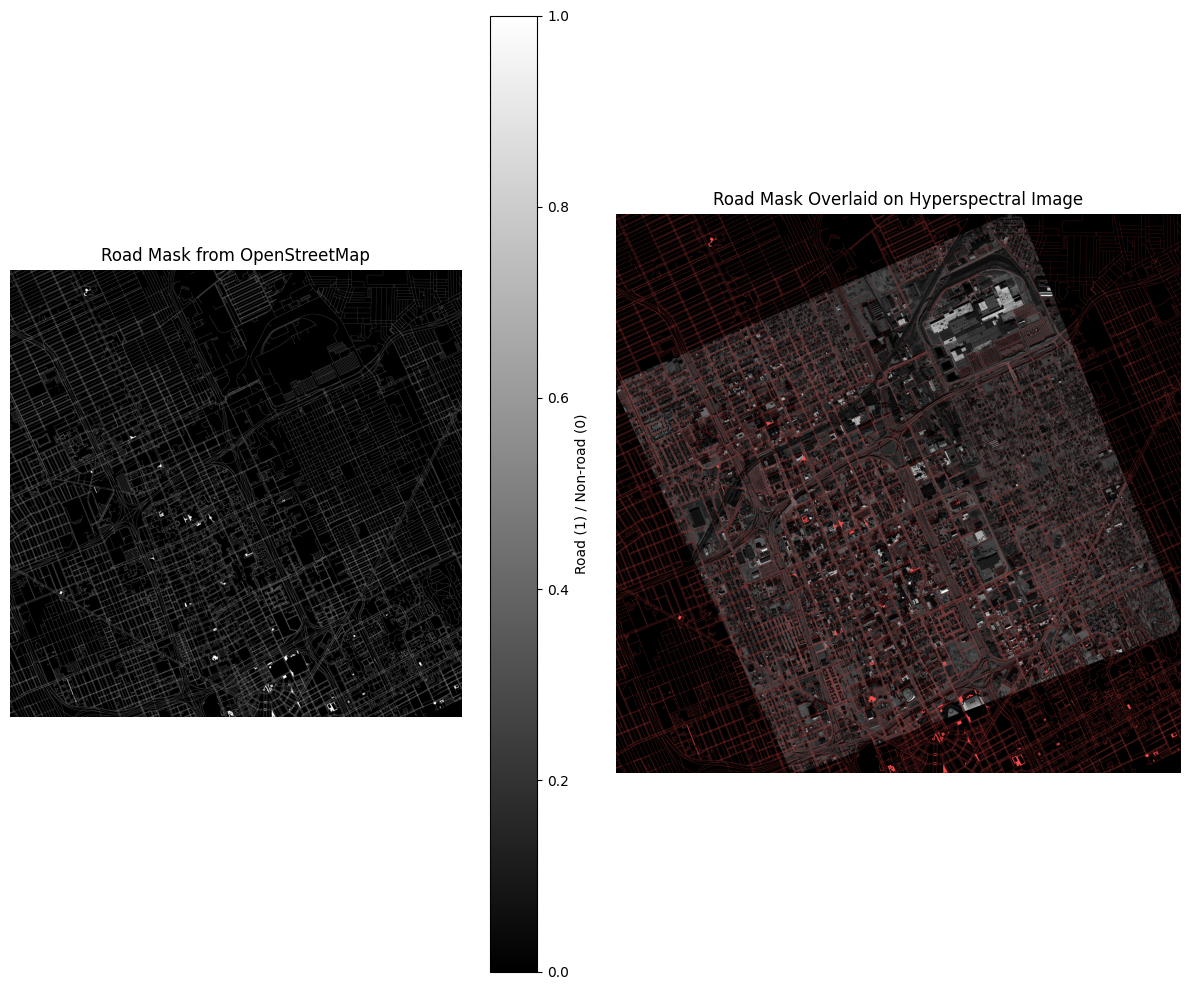


Road Mask Statistics:
  Total pixels: 30,901,997
  Road pixels: 2,200,584 (7.12%)
  Non-road pixels: 28,701,413 (92.88%)
  Mask shape: (5537, 5581)
  Mask dtype: bool


In [11]:
# Visualize road mask
# The road mask is a binary array where 1 = road, 0 = non-road
if isinstance(road_data.data, np.ndarray):
    plt.figure(figsize=(12, 10))
    
    # Create subplot for road mask
    plt.subplot(1, 2, 1)
    plt.imshow(road_data.data, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(label='Road (1) / Non-road (0)')
    plt.title('Road Mask from OpenStreetMap')
    plt.axis('off')
    
    # Create subplot showing road mask overlaid on hyperspectral image (if available)
    plt.subplot(1, 2, 2)
    if isinstance(hyperspectral_data.data, dict) and 'image' in hyperspectral_data.data:
        # Use first band or create RGB from multiple bands
        image = hyperspectral_data.data['image']
        if len(image.shape) == 3:
            # Use first band for grayscale display
            display_image = image[:, :, 0]
        else:
            display_image = image
        
        # Normalize image for display
        if display_image.max() > 0:
            display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min())
        
        # Overlay road mask in red
        overlay = np.zeros((*display_image.shape, 3))
        overlay[:, :, 0] = display_image  # R channel
        overlay[:, :, 1] = display_image  # G channel
        overlay[:, :, 2] = display_image  # B channel
        
        # Add red overlay for roads
        road_mask_resized = road_data.data
        if road_mask_resized.shape != display_image.shape:
            # Resize road mask to match image if needed
            from scipy.ndimage import zoom
            zoom_factors = (display_image.shape[0] / road_mask_resized.shape[0],
                          display_image.shape[1] / road_mask_resized.shape[1])
            road_mask_resized = zoom(road_mask_resized, zoom_factors, order=0)
        
        # Overlay roads in red
        road_pixels = road_mask_resized > 0
        overlay[road_pixels, 0] = 1.0  # Red channel
        overlay[road_pixels, 1] = 0.3  # Reduce green
        overlay[road_pixels, 2] = 0.3  # Reduce blue
        
        plt.imshow(overlay)
        plt.title('Road Mask Overlaid on Hyperspectral Image')
    else:
        # If no hyperspectral image, just show the mask again
        plt.imshow(road_data.data, cmap='gray', vmin=0, vmax=1)
        plt.title('Road Mask')
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_pixels = road_data.data.size
    road_pixels = np.sum(road_data.data > 0)
    non_road_pixels = total_pixels - road_pixels
    
    print(f"\nRoad Mask Statistics:")
    print(f"  Total pixels: {total_pixels:,}")
    print(f"  Road pixels: {road_pixels:,} ({100*road_pixels/total_pixels:.2f}%)")
    print(f"  Non-road pixels: {non_road_pixels:,} ({100*non_road_pixels/total_pixels:.2f}%)")
    print(f"  Mask shape: {road_data.data.shape}")
    print(f"  Mask dtype: {road_data.data.dtype}")
else:
    print(f"Visualization skipped: Road data is not a numpy array (type: {type(road_data.data)})")

## Stage 2: Data Processing

The processing stage includes:
- ROI (Region of Interest) processing: Crop + Normalization
- Road extraction
- PCI segmentation
- Data preprocessing for neural networks


### 2.1 ROI Processing


In [12]:
# Create ROI processor using loaded config
# ROI format: [xmin_cut, xmax_cut, ymin_cut, ymax_cut] = [lon_min, lon_max, lat_min, lat_max]
# Get ROI from config (first ROI in the list)
roi_bounds = config['data']['rois'][0] if 'rois' in config['data'] and config['data']['rois'] else None

if roi_bounds is None:
    # Fallback: use default ROI
    roi_bounds = [-83.098832, -83.015603, 42.331850, 42.39165]  # [lon_min, lon_max, lat_min, lat_max]
    print("⚠ No ROI found in config, using default")

roi_config = {
    'roi_bounds': roi_bounds,  # [xmin_cut, xmax_cut, ymin_cut, ymax_cut] = [lon_min, lon_max, lat_min, lat_max]
    'enum_data_source': config['data'].get('enum_data_source', 3),  # Get from config
    'coordinate_system': 'latlon',
}

roi_processor = ROIProcessor(roi_config)
print(f"Created processor: {roi_processor.name}")
print(f"Supported data types: {roi_processor.supported_data_types}")
print(f"ROI bounds: {roi_bounds}")
print(f"  Format: [lon_min, lon_max, lat_min, lat_max]")
print(f"  Longitude range: [{roi_bounds[0]:.6f}, {roi_bounds[1]:.6f}]")
print(f"  Latitude range: [{roi_bounds[2]:.6f}, {roi_bounds[3]:.6f}]")
print(f"Enum data source: {roi_config['enum_data_source']}")


Created processor: roi_processor
Supported data types: ['hyperspectral', 'ground_truth_pci']
ROI bounds: [-83.078832, -83.035603, 42.35185, 42.37165]
  Format: [lon_min, lon_max, lat_min, lat_max]
  Longitude range: [-83.078832, -83.035603]
  Latitude range: [42.351850, 42.371650]
Enum data source: 2


In [13]:
# Process ROI
# The ROI processor will crop the hyperspectral image to the specified ROI bounds
# and normalize the data, creating an enhanced RGB image
try:
    print("Processing ROI...")
    print(f"  Input image shape: {hyperspectral_data.data['image'].shape if isinstance(hyperspectral_data.data, dict) else 'N/A'}")
    
    roi_result = roi_processor.process_data(hyperspectral_data, roi_config)
    
    print(f"\n✓ ROI processing completed!")
    print(f"  Success: {roi_result.success}")
    print(f"  Processing time: {roi_result.processing_time:.4f}s")
    
    # Output data is now a dictionary with cropped image, coordinates, and RGB
    if isinstance(roi_result.data.data, dict):
        cropped_image = roi_result.data.data['image']
        cropped_lon = roi_result.data.data['lon_mat']
        cropped_lat = roi_result.data.data['lat_mat']
        rgb_enhanced = roi_result.data.data.get('RGB_enhanced')
        
        print(f"  Cropped image shape: {cropped_image.shape}")
        print(f"  Cropped lon_mat shape: {cropped_lon.shape}")
        print(f"  Cropped lat_mat shape: {cropped_lat.shape}")
        if rgb_enhanced is not None:
            print(f"  RGB enhanced shape: {rgb_enhanced.shape}")
        print(f"  Container shape (from image): {roi_result.data.shape}")
        print(f"  Optical center: {roi_result.data.metadata.get('optical_center', 'N/A')}")
        print(f"  Cropped rect: {roi_result.data.metadata.get('cropped_rect', 'N/A')}")
    else:
        print(f"  Output shape: {roi_result.data.shape}")
    
    print(f"\n  Metadata keys: {list(roi_result.data.metadata.keys())}")
    
    # Update data for next stage
    processed_data = roi_result.data
    
except Exception as e:
    print(f"\n⚠ Error processing ROI: {str(e)}")
    print("\nFull error traceback:")
    import traceback
    traceback.print_exc()
    print("\n" + "="*60)
    print("Using original data as fallback...")
    print("="*60)
    # Use original data as fallback
    processed_data = hyperspectral_data
    print(f"  Using original hyperspectral_data (shape: {hyperspectral_data.shape})")


Processing ROI...
  Input image shape: (5538, 5582, 6)
Optical center ROI in xy[column][row]: (1282, 1885)


✓ ROI processing completed!
  Success: True
  Processing time: 0.5425s
  Cropped image shape: (1903, 3010, 6)
  Cropped lon_mat shape: (1903, 3010)
  Cropped lat_mat shape: (1903, 3010)
  RGB enhanced shape: (1903, 3010, 3)
  Container shape (from image): (1903, 3010, 6)
  Optical center: (1282, 1885)
  Cropped rect: (1282, 1885, 4292, 3788)

  Metadata keys: ['dataset', 'input_path', 'data_type', 'rois', 'filename_NED', 'filename_RGB', 'roi_bounds', 'cropped_rect', 'optical_center', 'enum_data_source', 'processor']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00040112314480545525..5.282620179609086].


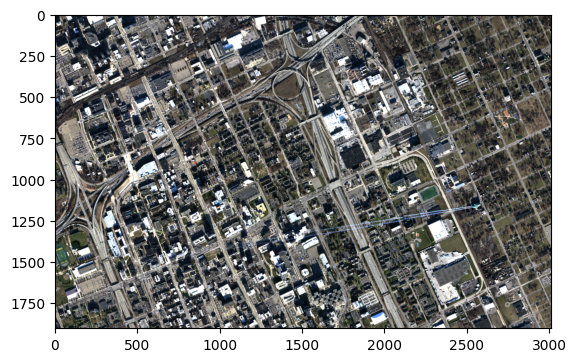

In [14]:
# plot the cropped image
plt.imshow(processed_data.data['RGB_enhanced'])
plt.show()


### 2.2 Road Extraction


In [15]:
# Create road extractor
road_extract_config = {
    'method': 'osm',  # or 'segmentation'
    'threshold': 0.5,
}

road_extractor = RoadExtractor(road_extract_config)
print(f"Created extractor: {road_extractor.name}")


Created extractor: road_extractor


✓ Road extraction completed!
  Success: True
  Output data type: road_mask
  Output shape: (1,)


TypeError: Invalid shape (1,) for image data

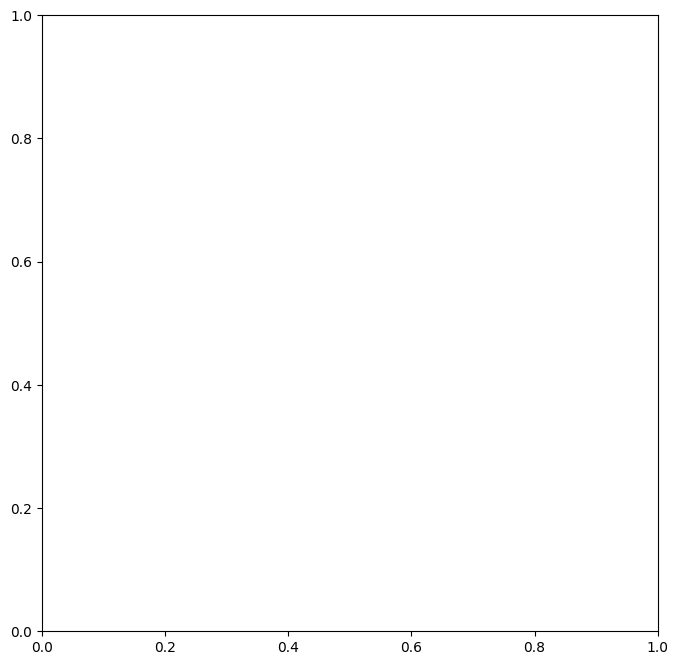

In [16]:
# Extract roads
road_result = road_extractor.process_data(processed_data, road_extract_config)

print(f"✓ Road extraction completed!")
print(f"  Success: {road_result.success}")
print(f"  Output data type: {road_result.data.data_type}")
print(f"  Output shape: {road_result.data.shape}")

# Visualize road mask
if isinstance(road_result.data.data, np.ndarray):
    plt.figure(figsize=(10, 8))
    plt.imshow(road_result.data.data, cmap='gray')
    plt.title('Extracted Road Network')
    plt.colorbar(label='Road (1) / Non-road (0)')
    plt.axis('off')
    plt.show()
    
    road_mask = road_result.data


### 2.3 PCI Segmentation


In [ ]:
# Create PCI segmenter
pci_seg_config = {
    'algorithm': 'dijkstra',  # or 'nearest_neighbor'
    'pci_values': [0, 1, 2, 3, 4],
}

pci_segmenter = PCISegmenter(pci_seg_config)
print(f"Created segmenter: {pci_segmenter.name}")


Created segmenter: pci_segmenter


✓ PCI segmentation completed!
  Success: True
  Output data type: pci_segmented
  Output shape: (200, 200)


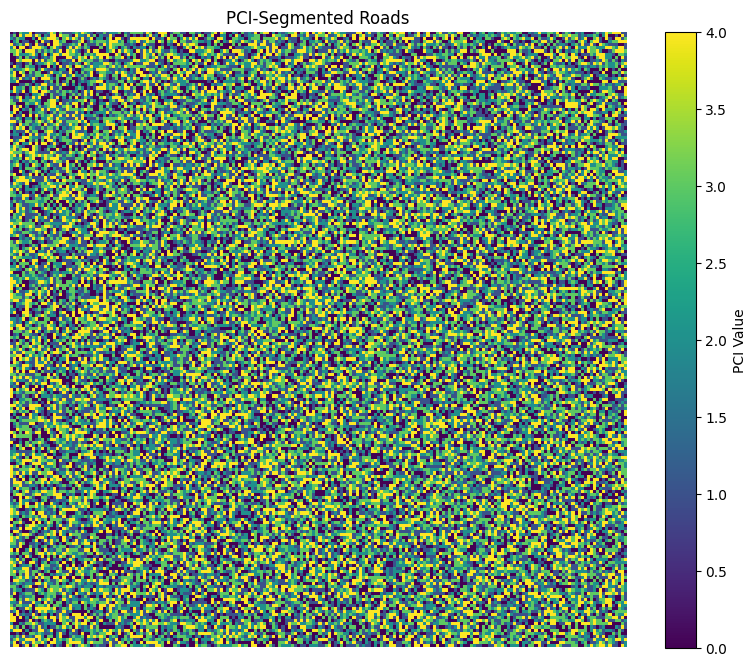

In [ ]:
# Segment roads with PCI values
# Combine road mask and ground truth for segmentation
pci_result = pci_segmenter.process_data(ground_truth_data, pci_seg_config)

print(f"✓ PCI segmentation completed!")
print(f"  Success: {pci_result.success}")
print(f"  Output data type: {pci_result.data.data_type}")
print(f"  Output shape: {pci_result.data.shape}")

# Visualize PCI-segmented roads
if isinstance(pci_result.data.data, np.ndarray):
    plt.figure(figsize=(10, 8))
    plt.imshow(pci_result.data.data, cmap='viridis', vmin=0, vmax=4)
    plt.colorbar(label='PCI Value')
    plt.title('PCI-Segmented Roads')
    plt.axis('off')
    plt.show()
    
    pci_segmented = pci_result.data


### 2.4 Data Preprocessing


In [ ]:
# Create data preprocessor
preprocess_config = {
    'normalize': True,
    'augmentation': False,
    'patch_size': (32, 32),
}

preprocessor = DataPreprocessor(preprocess_config)
print(f"Created preprocessor: {preprocessor.name}")
print(f"Supported data types: {preprocessor.supported_data_types}")


In [ ]:
# Preprocess data for neural network
prep_result = preprocessor.process_data(processed_data, preprocess_config)

print(f"✓ Data preprocessing completed!")
print(f"  Success: {prep_result.success}")
print(f"  Processing time: {prep_result.processing_time:.4f}s")
print(f"  Output shape: {prep_result.data.shape}")
print(f"  Normalized: {prep_result.data.metadata.get('normalize', False)}")
print(f"  Patch size: {prep_result.data.metadata.get('patch_size', 'N/A')}")

preprocessed_data = prep_result.data


## Stage 3: Model Training and Prediction

The APA API supports multiple model architectures:
- U-Net for segmentation
- CNN for classification
- Model manager for multiple models


### 3.1 U-Net Model


In [ ]:
# Create U-Net model
unet_config = {
    'input_size': (32, 32, 12),
    'n_classes': 4,
    'epochs': 10,  # Reduced for demo
    'batch_size': 32,
    'learning_rate': 0.001,
}

unet_model = UNetModel(unet_config)
print(f"Created model: {unet_model.name}")
print(f"Required config keys: {unet_model.required_config_keys}")


In [ ]:
# Train U-Net model
print("Training U-Net model...")
print("Note: This is a template - replace _train_impl() with your training logic")

try:
    train_result = unet_model.train(preprocessed_data, unet_config)
    
    print(f"\n✓ Training completed!")
    print(f"  Success: {train_result.success}")
    print(f"  Metrics: {train_result.metrics}")
    print(f"  Model info: {train_result.model_info}")
    
    # Plot training history if available
    if train_result.training_history:
        VisualizationUtils.plot_training_history(train_result.training_history)
        
except Exception as e:
    print(f"⚠ Training error (expected with template): {str(e)}")
    print("  This is normal - the model template needs your training logic")


In [ ]:
# Make predictions with U-Net
print("Making predictions with U-Net...")

try:
    pred_result = unet_model.predict(preprocessed_data)
    
    print(f"\n✓ Predictions generated!")
    print(f"  Success: {pred_result.success}")
    print(f"  Predictions shape: {pred_result.predictions.shape if hasattr(pred_result.predictions, 'shape') else type(pred_result.predictions)}")
    
    # Visualize predictions
    if isinstance(pred_result.predictions, np.ndarray):
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        if isinstance(ground_truth_data.data, np.ndarray):
            plt.imshow(ground_truth_data.data, cmap='viridis', vmin=0, vmax=4)
            plt.title('Ground Truth')
            plt.colorbar()
            plt.axis('off')
        
        plt.subplot(1, 2, 2)
        if len(pred_result.predictions.shape) == 2:
            plt.imshow(pred_result.predictions, cmap='viridis', vmin=0, vmax=3)
        else:
            plt.imshow(pred_result.predictions[:, :, 0], cmap='viridis')
        plt.title('Predictions')
        plt.colorbar()
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
except Exception as e:
    print(f"⚠ Prediction error (expected with template): {str(e)}")
    print("  This is normal - the model template needs your prediction logic")


### 3.2 CNN Model


In [ ]:
# Create CNN model
cnn_config = {
    'input_size': (32, 32, 12),
    'n_classes': 4,
    'epochs': 10,
    'batch_size': 32,
}

cnn_model = CNNModel(cnn_config)
print(f"Created model: {cnn_model.name}")


In [ ]:
# Train CNN model
print("Training CNN model...")

try:
    cnn_train_result = cnn_model.train(preprocessed_data, cnn_config)
    
    print(f"\n✓ CNN Training completed!")
    print(f"  Metrics: {cnn_train_result.metrics}")
    
except Exception as e:
    print(f"⚠ Training error (expected with template): {str(e)}")


### 3.3 Model Manager


In [ ]:
# Create model manager
model_manager = ModelManager()

# Add models
model_manager.add_model('unet', unet_model)
model_manager.add_model('cnn', cnn_model)

print(f"✓ Added {len(model_manager.models)} models to manager")
print(f"  Models: {list(model_manager.models.keys())}")
print(f"  Active model: {model_manager.active_model}")


In [ ]:
# Switch active model
model_manager.set_active_model('cnn')
print(f"✓ Switched active model to: {model_manager.active_model}")

# Make predictions with active model
try:
    active_pred = model_manager.predict(preprocessed_data)
    print(f"✓ Predictions from active model: {active_pred.success}")
except Exception as e:
    print(f"⚠ Prediction error: {str(e)}")


## Stage 4: Metrics and Evaluation


In [ ]:
# Calculate metrics
if isinstance(ground_truth_data.data, np.ndarray):
    # Create dummy predictions for demonstration
    y_true = ground_truth_data.data.flatten()
    y_pred = np.random.randint(0, 5, size=y_true.shape)  # Dummy predictions
    
    # Classification metrics
    class_metrics = MetricsCalculator.calculate_classification_metrics(y_true, y_pred)
    print("Classification Metrics:")
    for key, value in class_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    # Regression metrics
    reg_metrics = MetricsCalculator.calculate_regression_metrics(y_true, y_pred)
    print("\nRegression Metrics:")
    for key, value in reg_metrics.items():
        print(f"  {key}: {value:.4f}")
    
    # PCI-specific metrics
    pci_metrics = MetricsCalculator.calculate_pci_metrics(
        ground_truth_data.data, 
        y_pred.reshape(ground_truth_data.data.shape)
    )
    print("\nPCI-Specific Metrics:")
    for key, value in pci_metrics.items():
        if isinstance(value, float):
            print(f"  {key}: {value:.4f}")
        else:
            print(f"  {key}: {value}")
    
    # Confusion matrix
    cm = MetricsCalculator.calculate_confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    print("\nConfusion Matrix:")
    print(cm)
    
    # Classification report
    report = MetricsCalculator.generate_classification_report(y_true, y_pred, labels=[0, 1, 2, 3, 4])
    print("\nClassification Report:")
    print(report)


## Stage 5: Pipeline Orchestration

The APA API supports two types of pipelines:
- **APAPipeline**: Complete pre-configured pipeline
- **ModularPipeline**: Custom pipeline with user-defined stages


### 5.1 Complete APA Pipeline


In [ ]:
# Create complete APA pipeline
pipeline_config = {
    'data_import': {
        'input_path': 'data/Detroit',
        'dataset': 1,
    },
    'roi_processing': {
        'roi_bounds': [42.3, 42.4, -83.0, -82.9],
    },
    'road_extraction': {
        'method': 'osm',
    },
    'pci_segmentation': {
        'algorithm': 'dijkstra',
    },
    'data_preparation': {
        'normalize': True,
        'patch_size': [32, 32],
    },
    'model_training': {
        'model_type': 'unet',
        'input_size': [32, 32, 12],
        'n_classes': 4,
        'epochs': 10,
        'batch_size': 32,
    },
}

apa_pipeline = APAPipeline(pipeline_config)
print(f"Created pipeline: {apa_pipeline.name}")
print(f"Pipeline stages: {list(apa_pipeline.stages.keys())}")


In [ ]:
# Run complete pipeline
print("Running complete APA pipeline...")
print("Note: This will execute all stages in sequence")

try:
    pipeline_result = apa_pipeline.run_pipeline(None, pipeline_config)
    
    print(f"\n✓ Pipeline execution completed!")
    print(f"  Success: {pipeline_result.success}")
    print(f"  Execution time: {pipeline_result.execution_time:.2f}s")
    print(f"  Stages executed: {len(pipeline_result.stage_results)}")
    print(f"  Errors: {len(pipeline_result.errors)}")
    
    if pipeline_result.errors:
        print("\nErrors encountered:")
        for error in pipeline_result.errors:
            print(f"  - {error}")
    
    # Show stage results
    print("\nStage Results:")
    for stage_name, result in pipeline_result.stage_results.items():
        if hasattr(result, 'success'):
            status = "✓" if result.success else "✗"
            print(f"  {status} {stage_name}: {result.message}")
        else:
            print(f"  ? {stage_name}: {type(result)}")
            
except Exception as e:
    print(f"⚠ Pipeline error: {str(e)}")
    print("  This is expected - implementations are templates")
